In [1]:
from config2spec.policies.policy import PolicyType
import pickle

#with open('data_fixed_prev.pkl', 'rb') as file:
with open('data_no_waypoints.pkl', 'rb') as file:
    data = pickle.load(file)

policies = data["policies"]
failed_links = data["failed_links"]
failures = []

for policies, links in zip(policies,failed_links):
    fail = [link.edge for link in links]
    failures += fail
    print(len(policies),fail)
    reachability_count = sum(1 for item in policies if item[0] == PolicyType.Reachability)
    loadbalancing_count = sum(1 for item in policies if (item[0] == PolicyType.LoadBalancingSimple or item[0] == PolicyType.LoadBalancingEdgeDisjoint or item[0] == PolicyType.LoadBalancingNodeDisjoint))
    waypointing_count = sum(1 for item in policies if item[0] == PolicyType.Waypoint)
    print(f"     R: {reachability_count} L: {loadbalancing_count} W: {waypointing_count} - {len(policies) - (reachability_count+loadbalancing_count+waypointing_count)}")

failures.insert(0,())

1398 []
     R: 1056 L: 342 W: 0 - 0
1419 [('dublin', 'london')]
     R: 1023 L: 331 W: 0 - 65
1337 [('brussels', 'frankfurt')]
     R: 1088 L: 249 W: 0 - 0
1473 [('warsaw', 'frankfurt')]
     R: 1088 L: 385 W: 0 - 0
1432 [('madrid', 'barcelona')]
     R: 1088 L: 344 W: 0 - 0
1431 [('zurich', 'geneva')]
     R: 1088 L: 343 W: 0 - 0
1462 [('milan', 'zurich')]
     R: 1088 L: 374 W: 0 - 0
1418 [('strasbourg', 'basel')]
     R: 1088 L: 330 W: 0 - 0
1446 [('kiev', 'bucharest')]
     R: 1088 L: 358 W: 0 - 0
1416 [('geneva', 'basel')]
     R: 1088 L: 328 W: 0 - 0
1459 [('vienna', 'milan')]
     R: 1088 L: 371 W: 0 - 0
1454 [('london', 'paris')]
     R: 1088 L: 366 W: 0 - 0
1427 [('amsterdam', 'london')]
     R: 1088 L: 339 W: 0 - 0
1441 [('istanbul', 'bucharest')]
     R: 1088 L: 353 W: 0 - 0
1452 [('brussels', 'paris')]
     R: 1088 L: 364 W: 0 - 0
1379 [('brussels', 'london')]
     R: 1088 L: 291 W: 0 - 0
1416 [('amsterdam', 'frankfurt')]
     R: 1088 L: 328 W: 0 - 0
1403 [('zurich', 'fran

In [25]:
# See how many of the original policies are kept in the subsequent runs

def check_policies_against_control(control, to_check):
    """For each policy list in the to_check list, this function computes the intersection with
    the policies in the control list and returns the intersection

    Args:
        control ([policies]): The list of policies to check against
        to_check ([[policies]]): A list of policies lists to get the intersection

    Returns:
        [intersections]: A list of all intersections
    """
    # Convert the control into a set
    control_set = set(control)

    intersections = []
    for policies in to_check:
        policies_set = set(policies)

        intersections.append(control_set.intersection(policies_set))

    return intersections

def normalise_edge(edge):
    """A function to fix the ordering of edges

    Args:
        edge ((src,dst)): a tuple representing an edge
    """
    return tuple(sorted(edge))

def getInvCount(arr):
    """A function to count inversions in an array

    Args:
        arr ([]): list to count inversions in

    Returns:
        int: number of inversions
    """
    n = len(arr)
    inv_count = 0
    for i in range(n): 
        for j in range(i + 1, n): 
            if (arr[i] < arr[j]): 
                inv_count += 1
    return inv_count 

def overall_ranking(lists, n):
    """
    Calculate an overall ranking that takes into account multiple sorted lists.

    Parameters:
    lists (list): A list of n copies of the same list, each sorted according to a different criterion.
    n (int): The number of sorted lists.

    Returns:
    list: The overall ranking based on the average rank of elements across sorted lists.

    Example:
    >>> lists = [[10, 5, 8, 12, 3, 15], [3, 5, 8, 10, 12, 15]]
    >>> overall_ranking(lists, 2)
    [5, 10, 8, 3, 12, 15]
    """

    # Create dictionaries to store ranks for each sorted list
    rank_dicts = [{} for _ in range(n)]

    # Calculate ranks for each list
    for i in range(n):
        rank_dicts[i] = {value: rank for rank, value in enumerate(lists[i], start=1)}
    
    # Calculate the average rank for each element
    average_rank_dict = {}
    for value in lists[0]:
        average_rank = sum(rank_dict.get(value, n + 1) for rank_dict in rank_dicts) / n
        average_rank_dict[value] = average_rank

    # Sort the elements based on the average rank
    overall_ranking = sorted(lists[0], key=lambda x: average_rank_dict[x])

    return overall_ranking


1294
We get a score of 419


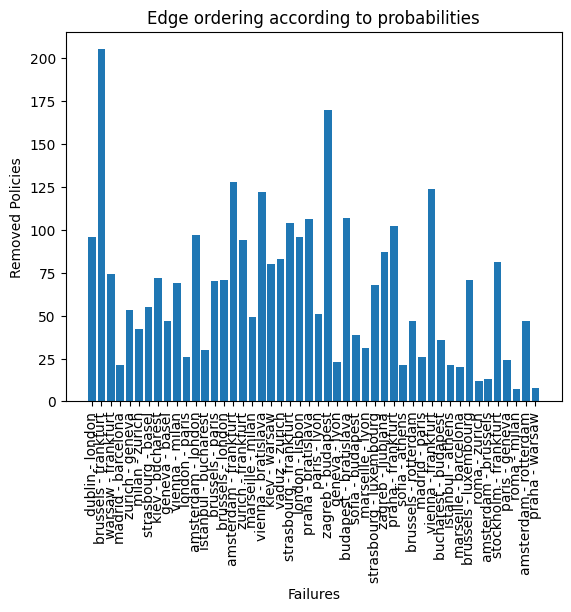

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Get interections 
# For each edge, the intersection are the policies that were in the original policies
intersections = check_policies_against_control(data["policies"][0], data["policies"])
diffs = []
diff_dict = {}

for intersection, all_policies, fail_edge in zip(intersections, data["policies"], failures):
    diffs.append(len(data["policies"][0]) - len(intersection))
    diff_dict[normalise_edge(fail_edge)] = set(data["policies"][0]) - intersection

print(len(data["policies"][0]) - len(diff_dict[('frankfurt', 'strasbourg')]))

sequence = diffs[1:]
print(f"We get a score of {getInvCount(sequence)}")

plt.bar([f"{fail_edge[0]} - {fail_edge[1]}" for fail_edge in failures[1:]], sequence)
plt.xlabel('Failures')
plt.ylabel('Removed Policies')
plt.title('Edge ordering according to probabilities')
plt.xticks(rotation=90)
plt.show()

We get a score of 195


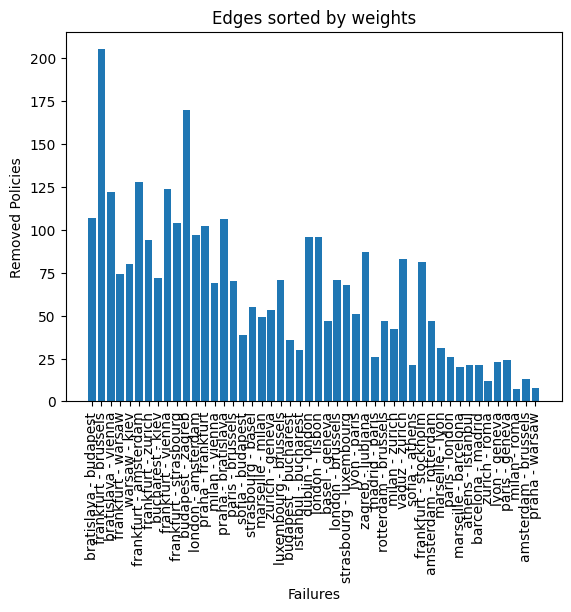

In [27]:
# I want to analyse the weights the sum sampler associates to the different links
import networkx as nx

graphs = []

for i in range(48):
    with open(f'weight_data/graph-no-waypoints-{i}.pkl', 'rb') as file:
    #with open(f'weight_data/graph-{i}.pkl', 'rb') as file:
        graph = pickle.load(file)
    graphs.append(graph)

all_edges = sorted(graphs[0].edges.data("weight"), key=lambda x: x[2], reverse=True)

all_edges_prev = all_edges
for graph in graphs:
    all_edges = sorted(graph.edges.data("weight"), key=lambda x: x[2], reverse=True)
    assert all_edges == all_edges_prev
    all_edges_prev = all_edges

# The egdes indeed are the same for every run

sequence = [len(diff_dict[normalise_edge((key[0],key[1]))]) for key in all_edges]
print(f"We get a score of {getInvCount(sequence)}")


plt.bar([f"{edge[0]} - {edge[1]}" for edge in all_edges], sequence)
plt.xlabel('Failures')
plt.ylabel('Removed Policies')
plt.title('Edges sorted by weights')
plt.xticks(rotation=90)
plt.show()


We get a score of 176


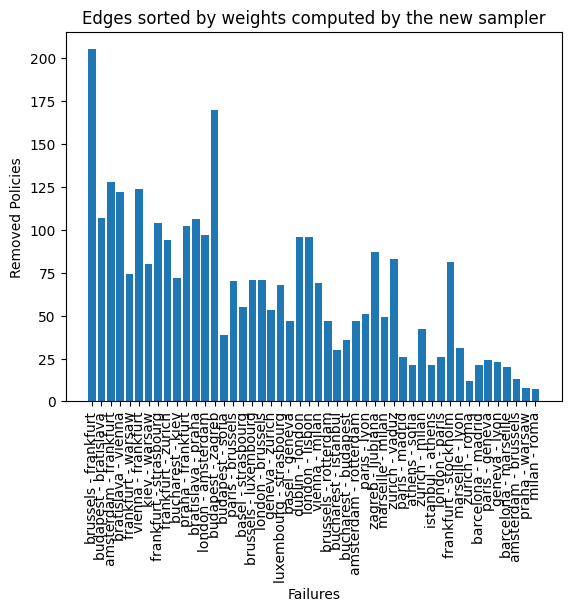

In [28]:
with open(f'weight_data/graph-no-waypoints-new-sampler.pkl', 'rb') as file:
#with open(f'weight_data/graph-new-sampler.pkl', 'rb') as file:
    graph = pickle.load(file)

sorts = []
for type in ["loadbalancing", "reachability"]: #, "waypoint"]:
    sorts.append(sorted(graph.edges.data(f"{type}_weight"), key=lambda x: x[2], reverse=True))
all_edges = overall_ranking(sorts, len(sorts))

#all_edges = sorted(graph.edges.data("weight"), key=lambda x: x[2], reverse=True)


sequence = [len(diff_dict[normalise_edge((key[0],key[1]))]) for key in all_edges]
print(f"We get a score of {getInvCount(sequence)}")


plt.bar([f"{edge[0]} - {edge[1]}" for edge in all_edges], sequence)
plt.xlabel('Failures')
plt.ylabel('Removed Policies')
plt.title('Edges sorted by weights computed by the new sampler')
plt.xticks(rotation=90)
plt.show()


In [29]:
from config2spec.policies.policy import Policy

# Get the policies that get eliminated for a specific edge failure
for policy in diff_dict[normalise_edge(("brussels","frankfurt"))]:
        policy_type, destination, specifics, source = policy
        policy_object = Policy.get_policy(policy_type, [source], [destination], specifics)
        print(policy_object)

loadbalancing policy: {strasbourg}->{rotterdam:FastEthernet0/0 (100.0.9.0/24)}, negate=False - NumPaths 3
loadbalancing policy: {rotterdam}->{bucharest:FastEthernet0/0 (100.0.23.0/24)}, negate=False - NumPaths 2
loadbalancing policy: {luxembourg}->{bratislava:FastEthernet0/0 (100.0.13.0/24)}, negate=False - NumPaths 4
loadbalancing policy: {milan}->{luxembourg:FastEthernet0/0 (100.0.6.0/24)}, negate=False - NumPaths 4
loadbalancing policy: {paris}->{sofia:FastEthernet0/0 (100.0.26.0/24)}, negate=False - NumPaths 2
loadbalancing policy: {frankfurt}->{dublin:FastEthernet0/0 (100.0.17.0/24)}, negate=False - NumPaths 2
loadbalancing policy: {zagreb}->{dublin:FastEthernet0/0 (100.0.17.0/24)}, negate=False - NumPaths 2
loadbalancing policy: {brussels}->{sofia:FastEthernet0/0 (100.0.26.0/24)}, negate=False - NumPaths 2
loadbalancing policy: {roma}->{paris:FastEthernet0/0 (100.0.3.0/24)}, negate=False - NumPaths 2
loadbalancing policy: {basel}->{barcelona:FastEthernet0/0 (100.0.18.0/24)}, nega

In [30]:

with open('data_original_run.pkl', 'rb') as file:
    data = pickle.load(file)

policies = data["policies"]
failed_links = data["failed_links"]
changes = data["changes"]

for policy, failures, change in zip(policies, failed_links, changes):
    edges = [link.edge for link in failures]
    
    print(len(policy),edges, change)

2266 [] 1.0
2347 [('brussels', 'paris')] 0.040158870255957636
2074 [('warsaw', 'frankfurt')] 0.1425287356321839
2295 [('milan', 'zurich')] 0.013404825737265416
2256 [('amsterdam', 'london')] 0.03641304347826087
2198 [('frankfurt', 'brussels')] 0.04117315284827975
2217 [('strasbourg', 'frankfurt')] 0.01
2402 [('vienna', 'milan')] 0.0255496137849079
2012 [('warsaw', 'kiev')] 0.01768292682926829
2136 [('zagreb', 'budapest')] 0.09931719428926133
2241 [('rotterdam', 'brussels')] 0.0
2273 [('milan', 'marseille')] 0.012405237767057202
2242 [('basel', 'strasbourg')] 0.0027913468248429866
2234 [('praha', 'frankfurt')] 0.008397480755773267
2226 [('vienna', 'frankfurt')] 0.0
2291 [('madrid', 'barcelona')] 0.0
2261 [('athens', 'istanbul')] 0.0
2139 [('dublin', 'london')] 0.09174311926605505
2228 [('istanbul', 'bucharest')] 0.0
2327 [('sofia', 'budapest')] 0.0
2077 [('lisbon', 'london')] 0.14219114219114218
2260 [('frankfurt', 'zurich')] 0.0
2250 [('basel', 'geneva')] 0.0018115942028985507
2258 [('